In [18]:
# Collected job data from Lisa using the following command:
# sacct -a --starttime 2020-01-01 --format=jobid,gid,uid,partition,submit,start,end,elapsedraw,cputimeraw,ncpus,nnodes,nodelist,exitcode,state,timelimit > $HOME/jobdata.csv

# Required packages for processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, datetime, pytz
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter
from datetime import date, datetime, time

%matplotlib inline

In [5]:
# Required preprocessing/parsing of the job data
def preprocess_jobdata_to_df(name):
    with open(os.path.join(location_job_data_csv, name),'r') as file:
        filedata = file.read()
        filedata = filedata.replace('None assigned','NoneAssigned')
    with open(os.path.join(location_job_data_csv, str('processed_'+name)),'w') as file:
        file.write(filedata)
    jobdata = pd.read_fwf(os.path.join(location_job_data_csv, str('processed_'+name)), delimiter=r"\s+", header=None)#, low_memory=False)
    jobdata = jobdata.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    jobdata = jobdata.rename(columns=jobdata.iloc[0]).drop(jobdata.index[0])
    jobdata = jobdata.iloc[1:]
    jobdata = jobdata.astype({"ElapsedRaw": int, "CPUTimeRAW": int, "NCPUS": int})
    return(jobdata)


In [8]:
# Import job data
location_job_data_csv = "path to jobdata"
jobdata = preprocess_jobdata_to_df('jobdata.csv')
print(jobdata)

               JobID    GID    UID  Partition               Submit  \
2            4174135  49909  50279     normal  2019-12-27T09:09:30   
3            4174136  49909  50279     normal  2019-12-27T09:09:41   
4            4174921  49909  50279     normal  2019-12-27T12:13:55   
5            4174923  49909  50279     normal  2019-12-27T12:14:00   
6         4175534_16  49826  50196     normal  2019-12-27T14:52:15   
...              ...    ...    ...        ...                  ...   
3198112  6992601.bat                           2020-12-03T08:53:17   
3198113  6992601.ext                           2020-12-03T08:53:17   
3198114      6992602  49208  49531     normal  2020-12-03T08:53:42   
3198115      6992603  49206  49529  gpu_titan  2020-12-03T08:54:57   
3198116  6992603.ext                           2020-12-03T08:55:03   

                       Start                  End  ElapsedRaw  CPUTimeRAW  \
2        2019-12-27T11:31:11  2020-01-01T11:27:20      431769     6908304   
3    

In [ ]:
jobdata.dtypes

In [9]:
# Some extra preprocessing required for the job data, e.g. filtering out irrelevant login nodes
filtered_jobs = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
filtered_jobs = filtered_jobs[(~filtered_jobs["NodeList"].str.contains("None")) & (~filtered_jobs["NodeList"].str.contains("software")) & (~filtered_jobs["NodeList"].str.contains("login"))]
filtered_jobs["ElapsedRaw"] = filtered_jobs["ElapsedRaw"].apply(lambda x: (x / 60) / 60)
print(filtered_jobs)

              JobID    GID    UID  Partition               Submit  \
14       4175808_96  41405  41660     normal  2019-12-27T20:13:31   
15       4175808_97  41405  41660     normal  2019-12-27T20:13:31   
16       4175808_98  41405  41660     normal  2019-12-27T20:13:31   
17       4175808_99  41405  41660     normal  2019-12-27T20:13:31   
18       4175810_79  41405  41660     normal  2019-12-27T20:13:31   
...             ...    ...    ...        ...                  ...   
2311012     6495697  49515  49887  gpu_titan  2020-08-06T23:48:03   
2311013     6495698  49515  49887  gpu_titan  2020-08-06T23:51:00   
2311014     6495699  50355  50721  gpu_titan  2020-08-06T23:51:33   
2311015     6495700  50355  50721  gpu_titan  2020-08-06T23:53:17   
2311040     6495725  50355  50721  gpu_titan  2020-08-06T23:56:55   

                       Start                  End  ElapsedRaw  CPUTimeRAW  \
14       2019-12-31T20:18:11  2020-01-01T02:53:31    6.588889      379520   
15       2019-12-

In [ ]:
# Generate array containing counts of job lenght 
counts = np.unique(filtered_jobs["ElapsedRaw"].values, return_counts=True)
print(counts)

In [ ]:
# Visualize results
fig = plt.figure()
plt.yscale("log")
plt.locator_params(axis='y', numticks=12)
plt.bar(counts[0], counts[1], width=1)
plt.xlabel("Job duration (hours)")
plt.ylabel("Jobs")
plt.tight_layout()
fig.savefig("job_duration_count.pdf")

In [ ]:
# Generate PDF/CDF
pdf = counts[1] / np.sum(counts[1])
cdf = np.cumsum(pdf)
fig = plt.figure()

plt.ylim(0,1.05)
plt.plot(counts[0], cdf, drawstyle='steps')
plt.xscale("log")
plt.xlabel("Job duration (hours)")
plt.ylabel("Fraction of total jobs")
plt.tight_layout()
fig.savefig("job_duration_cdf.pdf")

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Job duration (hours)')
ax1.set_ylabel('PDF')
plt.ylim(-0.05,1.05)
plt.xscale("log")
ax1.plot(counts[0], pdf, color='black', drawstyle='steps')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('CDF - Fraction of total jobs', color=color)
ax2.plot(counts[0], cdf, color=color, drawstyle='steps')
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(-0.05,1.05)

fig.tight_layout()
plt.show()
fig.savefig("job_duration_cdf_pdf.pdf")

In [10]:
# Generate array containing counts of cpu core allocation for jobs 
counts_cpus = np.unique(filtered_jobs["NCPUS"].values, return_counts=True)
print(counts_cpus)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  16,
        18,  20,  21,  24,  26,  30,  32,  36,  40,  48,  64,  72,  80,
        96, 112, 120, 128, 144, 160, 176, 192, 208, 224, 240, 256, 288,
       320, 384, 400, 448, 480, 496, 512, 576]), array([  11399,    4926,   25710,    1775,     143,   12720,       5,
           995,      24,      42,   16193,       2, 2133672,      13,
          6270,       1,    8311,       1,       2,    8579,      43,
            60,    5004,    4129,      35,    1131,     228,       9,
            10,    5897,      14,     411,       9,      90,       5,
             5,     123,     336,       2,      36,       1,      11,
             1,       4,       1,      78,       1]))


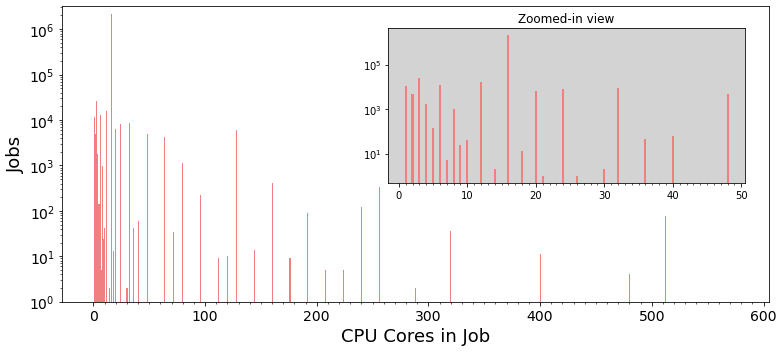

In [27]:
# Visualize results
fig, ax = plt.subplots(figsize=(11,5))

plt.yscale("log")
plt.ylim(bottom=1)
plt.ylim(top=10**6.5)
plt.bar(counts_cpus[0], counts_cpus[1], width=1, color="lightcoral")
plt.xlabel("CPU Cores in Job", fontsize=18)

majors = [0, 100, 200, 300, 400, 500, 600]
ax.xaxis.set_major_locator(FixedLocator(majors))
ax.xaxis.set_minor_locator(FixedLocator((np.arange(min(counts_cpus[0]-1), 600, 10))))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.ylabel("Jobs", fontsize=18)
plt.tight_layout()

a = plt.axes([.495, .48, .45, .43], facecolor='lightgrey')
plt.bar(counts_cpus[0][0:23], counts_cpus[1][0:23], width=0.3, color="lightcoral")
plt.title('Zoomed-in view')
plt.yscale("log")
majors_2 = [0, 10, 20, 30, 40, 50]
a.xaxis.set_major_locator(FixedLocator(majors_2))
a.xaxis.set_minor_locator(FixedLocator((np.arange(min(counts_cpus[0]-1), 50, 1))))

plt.show()
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"job_cpus_count_zoom_{date_time}.pdf")

In [ ]:
# Plot PDF/CDF
pdf = counts_cpus[1] / np.sum(counts_cpus[1])
cdf = np.cumsum(pdf)
fig = plt.figure()
plt.ylim(0,1.05)
plt.plot(counts_cpus[0], cdf, drawstyle='steps')
plt.xscale("symlog")
plt.xlabel("CPU cores in job")
plt.ylabel("Fraction of total jobs")
plt.tight_layout()
fig.savefig("job_cpus_cdf.pdf")

In [ ]:
# Note there seems to be some issue with the plotting library, which does not seem to show every first 
# minor tick after a major tick on log/symlog scales, even when this is hard-coded like below
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of cores in job')
ax1.set_ylabel('PDF')
plt.ylim(-0.05,1.05)
plt.xscale("symlog", subsx = [1,2,3,4,5,6,7,8,9])
ax1.plot(counts_cpus[0], pdf, color='black', drawstyle='steps')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('CDF - Fraction of total jobs', color=color)
ax2.plot(counts_cpus[0], cdf, color=color, drawstyle='steps')
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(-0.05,1.05)

fig.tight_layout()
plt.show()
fig.savefig("job_cpus_cdf_pdf.pdf")

In [20]:
# Generate list of dates in dataset, again excluding any login nodes from the data
group_date = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
group_date = group_date[(~group_date["NodeList"].str.contains("None")) & (~group_date["NodeList"].str.contains("software")) & (~group_date["NodeList"].str.contains("login"))]
group_date["Submit"] = pd.to_datetime(group_date["Submit"], utc=True)
group_date = group_date.set_index("Submit")
group_date = group_date.groupby(group_date.index.date).count()
datelist = list(group_date.index.values) 
submissionlist = group_date["JobID"].tolist()

In [ ]:
group_date = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
group_date = group_date[(~group_date["NodeList"].str.contains("None")) & (~group_date["NodeList"].str.contains("software")) & (~group_date["NodeList"].str.contains("login"))]
group_date["squashed_area"] = group_date["ElapsedRaw"] * group_date["NCPUS"]
group_date["Submit"] = pd.to_datetime(group_date["Submit"], utc=True)
group_date = group_date.set_index("Submit")
daily_squashed_area = group_date['squashed_area'].resample('D').sum()

fig = plt.figure()
plt.yscale("log")
plt.ylim(bottom=1)
plt.ylim(top=10**9.5)
plt.locator_params(axis='y', numticks=12)
plt.bar(datelist, daily_squashed_area, width=1)
plt.xlabel("Date")
plt.ylabel("CPU-Hours")
plt.tight_layout()
fig.savefig("job_squashed_area.pdf")

In [ ]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.bar(datelist, daily_squashed_area, width=1)
ax2.bar(datelist, daily_squashed_area, width=1)

ax.set_yscale("log")
ax2.set_yscale("log")

# zoom-in / limit the view to different portions of the data
ax.set_ylim(10**7,10**9.25)
ax2.set_ylim(10**0, 10**3)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xlabel("Date")
plt.ylabel("CPU-Hours")
plt.tight_layout()
f.savefig("job_squashed_area_split.pdf")

<ipython-input-26-465950c4d018>:3: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  plt.ylim(bottom=1)


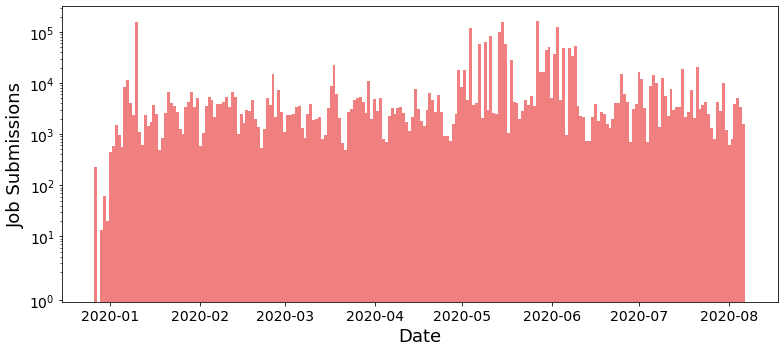

In [26]:
fig, ax = plt.subplots(figsize=(11,5))
plt.yscale("symlog", subsy = [1,2,3,4,5,6,7,8,9])
plt.ylim(bottom=1)
plt.ylim(top=10**5.5)
plt.locator_params(axis='y', numticks=12)
plt.bar(datelist, submissionlist, width=1, color="lightcoral")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Job Submissions", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout()
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"job_submission_count_{date_time}.pdf")